# Homework 2 Write Up

Make necessary enviroment

In [2]:
import numpy as np
import math
from statistics import mean
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_score
import glob
import os

# Utils

In [3]:
class Atom:
    """
    A simple class for an amino acid residue
    """

    def __init__(self, type):
        self.type = type
        self.coords = (0.0, 0.0, 0.0)

    # Overload the __repr__ operator to make printing simpler.
    def __repr__(self):
        return self.type

class Residue:
    """
    A simple class for an amino acid residue
    """

    def __init__(self, type, number):
        self.type = type
        self.number = number
        self.atoms = []

    # Overload the __repr__ operator to make printing simpler.
    def __repr__(self):
        return "{0} {1}".format(self.type, self.number)

class ActiveSite:
    """
    A simple class for an active site
    """

    def __init__(self, name):
        self.name = name
        self.residues = []
        self.newresidues = []

    # Overload the __repr__ operator to make printing simpler.
    def __repr__(self):
        return self.name

# io

In [4]:
def read_active_sites(dir):
    """
    Read in all of the active sites from the given directory.

    Input: directory
    Output: list of ActiveSite instances
    """
    files = glob.glob(dir + '/*.pdb')

    active_sites = []
    # iterate over each .pdb file in the given directory
    for filepath in glob.iglob(os.path.join(dir, "*.pdb")):

        active_sites.append(read_active_site(filepath))

    print("Read in %d active sites"%len(active_sites))

    return active_sites


def read_active_site(filepath):
    """
    Read in a single active site given a PDB file

    Input: PDB file path
    Output: ActiveSite instance
    """
    basename = os.path.basename(filepath)
    name = os.path.splitext(basename)

    if name[1] != ".pdb":
        raise IOError("%s is not a PDB file"%filepath)

    active_site = ActiveSite(name[0])

    r_num = 0

    # open pdb file
    with open(filepath, "r") as f:
        # iterate over each line in the file
        for line in f:
            if line[0:3] != 'TER':
                # read in an atom
                atom_type = line[13:17].strip()
                x_coord = float(line[30:38])
                y_coord = float(line[38:46])
                z_coord = float(line[46:54])
                atom = Atom(atom_type)
                atom.coords = (x_coord, y_coord, z_coord)

                residue_type = line[17:20]
                residue_number = int(line[23:26])

                # make a new residue if needed
                if residue_number != r_num:
                    residue = Residue(residue_type, residue_number)
                    r_num = residue_number

                # add the atom to the residue
                residue.atoms.append(atom)

            else:  # I've reached a TER card
                active_site.residues.append(residue)

    return active_site


def write_clustering(filename, clusters):
    """
    Write the clustered ActiveSite instances out to a file.

    Input: a filename and a clustering of ActiveSite instances
    Output: none
    """

    out = open(filename, 'w')

    for i in range(len(clusters)):
        out.write("\nCluster %d\n--------------\n" % i)
        for j in range(len(clusters[i])):
            out.write("%s\n" % clusters[i][j])

    out.close()


def write_mult_clusterings(filename, clusterings):
    """
    Write a series of clusterings of ActiveSite instances out to a file.

    Input: a filename and a list of clusterings of ActiveSite instances
    Output: none
    """

    out = open(filename, 'w')

    for i in range(len(clusterings)):
        clusters = clusterings[i]

        for j in range(len(clusters)):
            out.write("\nCluster %d\n------------\n" % j)
            for k in range(len(clusters[j])):
                out.write("%s\n" % clusters[j][k])

    out.close()

def make_matrix(sizex, sizey):
    """Creates a sizex by sizey matrix filled with zeros.
    """
    test = [[0]*sizey for i in  range(sizex)]
    return test

# Make a dictionary for the various combination of amino acid changes
AminoAcid = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE','PRO', 'SER', 'THR', 'TRP','TYR','VAL','ASX','XLE', 'GLX','XAA', '*']
data = pd.read_table('/Users/ijones1/Documents/hw2-skeleton/BLOSUM80.txt', sep=" ", header = None, names = AminoAcid)
data = data.set_index([pd.Index(AminoAcid)])
print(data)
Dict = {}
for i in AminoAcid:
    for j in AminoAcid:
        Dict[(i,j)]=data[i][j]

def local_align_Print(x, y):
    """
    Write a series of clusterings of ActiveSite instances out to a file.

    Input: a filename and a list of clusterings of ActiveSite instances
    Output: none
    """

    A = make_matrix(len(x) + 1, len(y) + 1)
    print(A)
    best = 0
    optloc = (0,0)
    # fill in A in the right order
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            # the local alignment recurrance rule:
            A[i][j] = max(
                A[i][j-1] + Dict[(x[i],'*')],
                A[i-1][j] + Dict[('*',y[j])],
                A[i-1][j-1] + Dict[(x[i],y[j])],
                0
            )
            print()
            print(A)
            # track the cell with the largest score
            if A[i][j] >= best:
                best = A[i][j]
                optloc = (i,j)
    # return the opt score and the best location
    return best, optloc

def local_align(x, y):
    """
    Write a series of clusterings of ActiveSite instances out to a file.

    Input: a filename and a list of clusterings of ActiveSite instances
    Output: none
    """

    A = make_matrix(len(x) + 1, len(y) + 1)
    best = 0
    optloc = (0,0)
    # fill in A in the right order
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            # the local alignment recurrance rule:
            A[i][j] = max(
                A[i][j-1] + Dict[(x[i],'*')],
                A[i-1][j] + Dict[('*',y[j])],
                A[i-1][j-1] + Dict[(x[i],y[j])],
                0
            )
            # track the cell with the largest score
            if A[i][j] >= best:
                best = A[i][j]
                optloc = (i,j)
    # return the opt score and the best location
    return best, optloc

     ALA  ARG  ASN  ASP  CYS  GLN  GLU  GLY  HIS  ILE  ...  SER  THR  TRP  \
ALA    5   -2   -2   -2   -1   -1   -1    0   -2   -2  ...    1    0   -3   
ARG   -2    6   -1   -2   -4    1   -1   -3    0   -3  ...   -1   -1   -4   
ASN   -2   -1    6    1   -3    0   -1   -1    0   -4  ...    0    0   -4   
ASP   -2   -2    1    6   -4   -1    1   -2   -2   -4  ...   -1   -1   -6   
CYS   -1   -4   -3   -4    9   -4   -5   -4   -4   -2  ...   -2   -1   -3   
GLN   -1    1    0   -1   -4    6    2   -2    1   -3  ...    0   -1   -3   
GLU   -1   -1   -1    1   -5    2    6   -3    0   -4  ...    0   -1   -4   
GLY    0   -3   -1   -2   -4   -2   -3    6   -3   -5  ...   -1   -2   -4   
HIS   -2    0    0   -2   -4    1    0   -3    8   -4  ...   -1   -2   -3   
ILE   -2   -3   -4   -4   -2   -3   -4   -5   -4    5  ...   -3   -1   -3   
LEU   -2   -3   -4   -5   -2   -3   -4   -4   -3    1  ...   -3   -2   -2   
LYS   -1    2    0   -1   -4    1    1   -2   -1   -3  ...   -1   -1   -4   

Above shows the Blosum matrix that was converted into a dictionary in order to perform a local alignment on sequences of interest

# Clustering

In [21]:
def get_order_residues_Print(active_sites):
    """
    Given a list of Active sites, add a feature 'newresidues' that is a list
    of residues 

    Input: a list of ActiveSite instances
    Output: Nothing

    Var:
    'res_mean' is a list of the mean atom coordinats for each residue
    'res' Keeps track of the current order of residues
    'res_list' is an array of the updated list of residue positions
    'Distance Matrix' is a matrix of the distance between 
    """

    for active in active_sites: # a for loop going throught the active sites
        print('The current Active Site is ...')
        print(active.name)
        res_mean = [] # store mean coords
        res = np.array([])
        res_list = np.array([]) # updated res list
        for residue in active.residues: # 
            # print('The current residue is...')
            # print('Residue')
            Atom = residue.atoms
            # print(Atom)
            Dim1 = np.array([])
            Dim2 = np.array([])
            Dim3 = np.array([])
            for a in Atom:
                Dim1 = np.append(Dim1, a.coords[0])
                Dim2 = np.append(Dim2, a.coords[1])
                Dim3 = np.append(Dim3, a.coords[2])
            res_mean += [list([np.mean(Dim1), np.mean(Dim2), np.mean(Dim3)])]
            res = np.append(res, residue.type)
        print(res)
        res_list = reorder_Print(res_mean, res)
        print(res_list)
        active.newresidues = (res_list)
    return

def get_order_residues(active_sites):
    """
    Given a list of Active sites, add a feature 'newresidues' that is a list
    of residues 

    Input: a list of ActiveSite instances
    Output: Nothing

    Var:
    'res_mean' is a list of the mean atom coordinats for each residue
    'res' Keeps track of the current order of residues
    'res_list' is an array of the updated list of residue positions
    'Distance Matrix' is a matrix of the distance between 
    """

    for active in active_sites: # a for loop going throught the active sites
        res_mean = [] # store mean coords
        res = np.array([])
        res_list = np.array([]) # updated res list
        for residue in active.residues: # 
            Atom = residue.atoms
            Dim1 = np.array([])
            Dim2 = np.array([])
            Dim3 = np.array([])
            for a in Atom:
                Dim1 = np.append(Dim1, a.coords[0])
                Dim2 = np.append(Dim2, a.coords[1])
                Dim3 = np.append(Dim3, a.coords[2])
            res_mean += [list([np.mean(Dim1), np.mean(Dim2), np.mean(Dim3)])]
            res = np.append(res, residue.type)
        res_list = reorder(res_mean, res)
        active.newresidues = (res_list)
    return

def reorder_Print(res_mean, res):  
    """
    Given a list of mean coordinate values for each residue in an active site. Return
    a reordered list based on the distance between each residue. With the two residues
    closest together next to each other in the array and then add 

    Input: mean coordinate positions of residues, and list of residues before reordering
    Output: reordered residues

    Var:
    """ 
    res_list = np.array([]) # updated res list         
    num_of_res = len(res_mean) # get the number of residues
    distance_matrix = [[0]*num_of_res for i in  range(num_of_res)]
    for i in range(num_of_res):
        for j in range(num_of_res):
            distance_matrix[i][j] = Euclidean_distance(res_mean[i],res_mean[j])
    dist = pd.DataFrame(distance_matrix)
    print('A euclidean distance matrix of each residue to every other residue within an active site')
    print(dist)
    visited = np.array([])
    minval = float("inf") 
    for i in range(len(dist)):
        col = dist[i]
        for j in range(len(dist)):
            if col[j] != 0 and minval > col[j]:
                    x = i
                    y = j
                    minval = col[j]
    dist[x][y]=float("inf")
    dist[y][x]=float("inf")
    res_list = np.append(res_list, res[x])
    res_list = np.append(res_list, res[y])
    visited = np.append(visited , [x])
    visited  = np.append(visited , [y])
    print('The index positions of the closest residues are...')
    print(visited)
    while len(visited) < len(res_mean):
        start=min_val(dist, x, visited)
        print('Distance from the first residue is...')
        print(start)
        end=min_val(dist, y, visited)
        print('Distance from the Last residue is...')
        print(end)
        if start[0] < end[0]:
            x=start[2]
            y1=start[1]
            dist[x][y1]=float("inf")
            dist[y1][x]=float("inf")
            visited  = np.insert(visited ,0, [x])
            res_list  = np.insert(res_list ,0, res[x])
            print('The index positions of the closest residues are...')
            print(visited)
            print(dist)
        else:
            x1=end[1]
            y=end[2]
            dist[x1][y]=float("inf")
            dist[y][x1]=float("inf")
            visited  = np.append(visited , [y])
            res_list  = np.append(res_list , res[y])
            print('The index positions of the closest residues are...')
            print(visited)
            print(dist)
    return res_list

def reorder(res_mean, res):  
    """
    Given a list of mean coordinate values for each residue in an active site. Return
    a reordered list based on the distance between each residue. With the two residues
    closest together next to each other in the array and then add 

    Input: mean coordinate positions of residues, and list of residues before reordering
    Output: reordered residues

    Var:
    """ 
    res_list = np.array([]) # updated res list         
    num_of_res = len(res_mean) # get the number of residues
    distance_matrix = [[0]*num_of_res for i in  range(num_of_res)]
    for i in range(num_of_res):
        for j in range(num_of_res):
            distance_matrix[i][j] = Euclidean_distance(res_mean[i],res_mean[j])
    dist = pd.DataFrame(distance_matrix)
    visited = np.array([])
    minval = float("inf") 
    for i in range(len(dist)):
        col = dist[i]
        for j in range(len(dist)):
            if col[j] != 0 and minval > col[j]:
                    x = i
                    y = j
                    minval = col[j]
    dist[x][y]=float("inf")
    dist[y][x]=float("inf")
    res_list = np.append(res_list, res[x])
    res_list = np.append(res_list, res[y])
    visited = np.append(visited , [x])
    visited  = np.append(visited , [y])
    while len(visited) < len(res_mean):
        start=min_val(dist, x, visited)
        end=min_val(dist, y, visited)
        if start[0] < end[0]:
            x=start[2]
            y1=start[1]
            dist[x][y1]=float("inf")
            dist[y1][x]=float("inf")
            visited  = np.insert(visited ,0, [x])
            res_list  = np.insert(res_list ,0, res[x])
        else:
            x1=end[1]
            y=end[2]
            dist[x1][y]=float("inf")
            dist[y][x1]=float("inf")
            visited  = np.append(visited , [y])
            res_list  = np.append(res_list , res[y])
    return res_list

def min_val(dist, column, visited):
    """
    Given a list of Active sites, add a feature 'newresidues' that is a list
    of residues 

    Input: 
    dist is a distance matrix
    column is an index of the column of the distancer matrix being visited
    vististed is a list that keeps track of which columns have already been added to the updated list
    Output: minimum vlaue

    Var:

    """
    minval = float("inf")
    test = range(len(dist))
    column
    col = dist[column]
    for j in test:
        if j not in visited and minval > col[j]:
                y1 = j
                minval = col[j]
    return minval, column, y1

def compute_similarity(site_a, site_b):
    """
    Compute the similarity between two given ActiveSite instances.

    Input: two ActiveSite instances
    Output: the similarity between them (a floating point number)
    """
    score = local_align(site_a.newresidues, site_b.newresidues)
    return score[0]

def compute_similarity_Print(site_a, site_b):
    """
    Compute the similarity between two given ActiveSite instances.

    Input: two ActiveSite instances
    Output: the similarity between them (a floating point number)
    """
    score = local_align_Print(site_a.newresidues, site_b.newresidues)
    return score[0]

def Euclidean_distance(x,y):
    """
    Given too vectors calculate the euclidean distance between them

    Input: Two Vectors
    Output: Distance
    """
    D = math.sqrt(sum([(a-b) ** 2 for a, b in zip(x, y)]))
    return D

def cluster_by_partitioning(active_sites, k):
    """
    Cluster a given set of ActiveSite instances using a partitioning method (K-means).

    Input: a list of ActiveSite instances
    Output: a clustering of ActiveSite instances
            (this is really a list of clusters, each of which is list of
            ActiveSite instances)
    """
    # Generate a score matrix based on similarity function for all the active sites
    #active_sites = active_sites[0:10]

    # Obtain is the updated matrix with score calculated from compute_similarity
    score_matrix = [[0]*len(active_sites) for i in  range(len(active_sites))]
    X = -1
    active = np.array([])
    for i in active_sites:
        X += 1
        Y = -1
        active = np.append(active, i.name)
        for j in active_sites:
            Y += 1
            score_matrix[X][Y] = compute_similarity(i,j) 


    # Initialization
    d = {'Scores': score_matrix, 'Cluster': [0] * (len(score_matrix)), 'Active':active}
    df = pd.DataFrame(data=d) # A dataframe of score comparison between all active sites and 
    # generate PCA to visulize all the vectors
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(score_matrix)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    df['principal component 1']=principalDf['principal component 1']
    df['principal component 2']=principalDf['principal component 2']


    # Select K random points based on the K
    randomK = random.sample(range(len(active_sites)), k) #Randomly select a number in the range of active sites without resampling
    centroids = [] 
    for i in randomK:
        centroids += ([score_matrix[i]]) # Get the score for the number selected and put it into a vector called centroid

    # Make figure before clustering
    make_figure(df)

    # Assign each active site to the nearest centroid
    df = assignment(df, centroids)


    # Show the figure after the first assignments
    make_figure(df)

    # Repeat till completing the cluster
    count = 0
    while True:
        closest_centroids = df['Cluster']
        centroids = update(df, centroids)
        # print(centroids)
        df = assignment(df, centroids)
        # print(df)
        count += 1
        # Break if the clusters are the same after recalc the centroid
        if closest_centroids.equals(df['Cluster']):
            break
        # Break if it has gone through reassignment 20 times
        if count == 20:
            break

    # What the final figure looks like
    make_figure(df)

    # obtain final list of cluster
    final_list = []
    for i in np.unique(df.Cluster):
        # print(i)
        # print(np.array(df[df['Cluster'] == i]['Active']))
        final_list += [(np.array(df[df['Cluster'] == i]['Active']))]

    return final_list, df

def make_figure(df):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(df['principal component 1']
               , df['principal component 2']
               , c = df['Cluster']
               , s = 50)
    ax.grid()
    plt.show()
    return

# Add additional columns for each centroid calculating the distance from every point to that centroid
def assignment(df, centroids):
    for i in range(len(centroids)):
        dist = np.array([])
        for j in range(len(df['Scores'])):
            temp = Euclidean_distance(df['Scores'][j], centroids[i])
            dist = np.append(dist, temp)
        df['distance_from_{}'.format(i)] = dist

    centroid_distance_cols = ['distance_from_{}'.format(i) for i in range(len(centroids))]
    # Selects the column of the centroid that they are closest too
    df['Cluster'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    # remove distance from
    df['Cluster'] = df['Cluster'].map(lambda x: int(x.lstrip('distance_from_')))
    return df

# Get the mean of each newly generates cluster
def update(df, centroids):
    for i in range(len(centroids)):
        centroids[i] = np.average(np.array(df[df['Cluster'] == i]['Scores']).tolist(), axis=0)
    return centroids

def cluster_hierarchically(active_sites, k):
    """
    Cluster the given set of ActiveSite instances using a hierarchical algorithm.                                                                  #

    Input: a list of ActiveSite instances
    Output: a list of clusterings
            (each clustering is a list of lists of Sequence objects)
    """

    # active_sites = active_sites[0:10]

    # Obtain similarity scores
    score_matrix = [[0]*len(active_sites) for i in  range(len(active_sites))]
    active = np.array([])
    X = -1
    for i in active_sites:
        X += 1
        Y = -1
        active = np.append(active, i.name)
        for j in active_sites:
            Y += 1
            score_matrix[X][Y] = compute_similarity(i,j)

    # Make score and cluster matrix
    d = {'Scores': score_matrix, 'Cluster': range(len(score_matrix)), 'Active':active}
    df = pd.DataFrame(data=d)
    # print(df)
    # Use PCA to visulize all the vectors
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(score_matrix)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    df['principal component 1']=principalDf['principal component 1']
    df['principal component 2']=principalDf['principal component 2']

    # visualize all unique clusters
    make_figure(df)




    dist = pd.DataFrame()
    for i in df.Cluster:
        d = np.array([])
        for j in df.Cluster:
            # gets the mean value of each cluster of points
            d = np.append(d, Euclidean_distance(np.average(np.array(df[df['Cluster'] == i]['Scores']).tolist(), axis=0),np.average(np.array(df[df['Cluster'] == j]['Scores']).tolist(), axis=0)))
        dist[i] = d
    # print(dist)

    # WHile cluster is less than K go through all the active sites and find the shortest active site distance and merge them together
    while k < len(np.unique(np.array([df.Cluster]))):
        # print(dist)
        minval = float("inf")
        for i in np.unique(df.Cluster):
            col = (np.array(dist[i]))
            for j in np.unique(df.Cluster):
                if col[j] != 0 and minval > col[j]:
                        x = i
                        y = j
                        minval = col[j]
                        # print(minval)
                        # print(x)
                        # print(y)
        
        # Cluster by having the mean dot
        mean = np.mean(np.array([(dist[x]),dist[y]]), axis =0)
        mean[x]=0
        # print(mean)

        # Cluster by the max distance between each cluster
        # print((np.array(dist[x]),np.array(dist[y])))
        MAX = np.fmax(np.array(dist[x]),np.array(dist[y]))
        # print(MAX)
        MAX[x]=0
        MAX[y]=0


        dist[x]=MAX

        df.Cluster=(df.replace(y,x)['Cluster'])
        # make_figure(df)
        # print(df.Cluster)

    
    # show the figure once it complete
    make_figure(df)
    # print(df)

    # obtain final list of cluster
    final_list = []
    for i in np.unique(df.Cluster):
        # print(i)
        # print(np.array(df[df['Cluster'] == i]['Active']))
        final_list += [(np.array(df[df['Cluster'] == i]['Active']))]

    # print(final_list)
    # print(final_list[0])

    return final_list, df

def cluster_hierarchically_print(active_sites, k):
    """
    Cluster the given set of ActiveSite instances using a hierarchical algorithm.                                                                  #

    Input: a list of ActiveSite instances
    Output: a list of clusterings
            (each clustering is a list of lists of Sequence objects)
    """

    # active_sites = active_sites[0:10]

    # Obtain similarity scores
    score_matrix = [[0]*len(active_sites) for i in  range(len(active_sites))]
    active = np.array([])
    X = -1
    for i in active_sites:
        X += 1
        Y = -1
        active = np.append(active, i.name)
        for j in active_sites:
            Y += 1
            score_matrix[X][Y] = compute_similarity(i,j)

    # Make score and cluster matrix
    d = {'Scores': score_matrix, 'Cluster': range(len(score_matrix)), 'Active':active}
    df = pd.DataFrame(data=d)
    # print(df)
    # Use PCA to visulize all the vectors
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(score_matrix)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    df['principal component 1']=principalDf['principal component 1']
    df['principal component 2']=principalDf['principal component 2']

    # visualize all unique clusters
    make_figure(df)




    dist = pd.DataFrame()
    for i in df.Cluster:
        d = np.array([])
        for j in df.Cluster:
            # gets the mean value of each cluster of points
            d = np.append(d, Euclidean_distance(np.average(np.array(df[df['Cluster'] == i]['Scores']).tolist(), axis=0),np.average(np.array(df[df['Cluster'] == j]['Scores']).tolist(), axis=0)))
        dist[i] = d
    # print(dist)

    # WHile cluster is less than K go through all the active sites and find the shortest active site distance and merge them together
    while k < len(np.unique(np.array([df.Cluster]))):
        # print(dist)
        minval = float("inf")
        for i in np.unique(df.Cluster):
            col = (np.array(dist[i]))
            for j in np.unique(df.Cluster):
                if col[j] != 0 and minval > col[j]:
                        x = i
                        y = j
                        minval = col[j]
                        # print(minval)
                        # print(x)
                        # print(y)
        
        # Cluster by having the mean dot
        mean = np.mean(np.array([(dist[x]),dist[y]]), axis =0)
        mean[x]=0
        # print(mean)

        # Cluster by the max distance between each cluster
        # print((np.array(dist[x]),np.array(dist[y])))
        MAX = np.fmax(np.array(dist[x]),np.array(dist[y]))
        # print(MAX)
        MAX[x]=0
        MAX[y]=0


        dist[x]=MAX

        df.Cluster=(df.replace(y,x)['Cluster'])
        make_figure(df)
        # print(df.Cluster)

    
    # show the figure once it complete
    make_figure(df)
    # print(df)

    # obtain final list of cluster
    final_list = []
    for i in np.unique(df.Cluster):
        # print(i)
        # print(np.array(df[df['Cluster'] == i]['Active']))
        final_list += [(np.array(df[df['Cluster'] == i]['Active']))]

    # print(final_list)
    # print(final_list[0])

    return final_list, df

def Test_Silhouette_partitioning(active_sites):
    k = range(2,11)
    score_matrix = [[0]*len(active_sites) for i in  range(len(active_sites))]
    active = np.array([])
    X = -1
    for i in active_sites:
        X += 1
        Y = -1
        active = np.append(active, i.name)
        for j in active_sites:
            Y += 1
            score_matrix[X][Y] = compute_similarity(i,j)

    # Make score and cluster matrix
    d = {'Scores': score_matrix, 'Active':active}
    df = pd.DataFrame(data=d)

    cluster = cluster_by_partitioning(active_sites, 2)
    
    for group in cluster:
        df[df['Active'] == group]['score']

    # for x in k:



    return

def Silhouette_partitioning(active_sites):
    k = range(2,5)
    score = []
    for x in k:
        df =cluster_by_partitioning(active_sites, x)[1]
        dist = pd.DataFrame()
        for i in range(len(df.Scores)):
            d = np.array([])
            for j in range(len(df.Scores)):
            # gets the mean value of each cluster of points
                d = np.append(d, Euclidean_distance(df.Scores[i],df.Scores[j]))
        dist[i] = d
        print(dist)
        silhouette_avg = silhouette_score(dist, np.array(df['Cluster']))
        score += ([x, silhouette_avg])
    print(score)
    return

# Main Analysis

Read in the active sites

In [7]:
active_sites = read_active_sites('/Users/ijones1/Documents/hw2-skeleton/data/')

Read in 136 active sites


Based on the mean distance of each residue reorder the residues for each active site so that the two closest residues are next to each other in a linear list and then the next closest residue is recursively added to the two residues. Lastly this new residue order is added to the class Activesite as 'self.newresidues'.

In [13]:
get_order_residues_Print(active_sites[0:2])

The current Active Site is ...
46495
['ASP' 'ASP' 'SER' 'ARG' 'ASP' 'LYS' 'ASP']
A euclidean distance matrix of each residue to every other residue within an active site
           0          1          2          3          4          5          6
0   0.000000   5.919706   6.035742   8.675584  10.002344   8.241239   7.119040
1   5.919706   0.000000   7.083964   5.593184  10.368537  11.416926   7.638094
2   6.035742   7.083964   0.000000   5.012994   7.986765   6.740485  11.584799
3   8.675584   5.593184   5.012994   0.000000  10.067525  11.072635  12.561031
4  10.002344  10.368537   7.986765  10.067525   0.000000   5.340089  10.887705
5   8.241239  11.416926   6.740485  11.072635   5.340089   0.000000  11.622366
6   7.119040   7.638094  11.584799  12.561031  10.887705  11.622366   0.000000
The index positions of the closest residues are...
[2. 3.]
Distance from the first residue is...
(6.035742342639893, 2, 0)
Distance from the Last residue is...
(5.593183712794276, 3, 1)
The index po

The two residues above were reoreder from ['ASP' 'ASP' 'SER' 'ARG' 'ASP' 'LYS' 'ASP'] and ['SER' 'GLU' 'ASP' 'GLU' 'ASP' 'LYS'] to ['ASP' 'LYS' 'SER' 'ARG' 'ASP' 'ASP' 'ASP'] and ['GLU' 'ASP' 'GLU' 'ASP' 'LYS' 'SER'] respectfully based on the mean distance of each residue. I will now show the score they get when performing local allignment between the two of them. Example of an updating matrix below. The final score is below.

In [15]:
compute_similarity_Print(active_sites[0], active_sites[0])

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 5, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 5, 0, 2, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 5, 0, 2, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0,

34

The Max similarity score will always be with itself as it will always have perfect alignment with it's self. While normal allignment would be taking Amino Acids(AA) that are linked by the protein background testing to see if other proteins have a similar order of AA. However, since active sites concist of AA not immediately next to each other this is not possible. Thus I performed a local alignment on a the vector of active site where the AA are ordered based off their distance towards each other. Thus if one AA has three ASP close together, then another protein with ASP or similarly acidic AA residues would recieve a higher similarity score than an active site with mainly basic AA residues for example. Additionally, the longer the similarity the higher the score. Furthermore, active sites of protiens with similar functions would have the location of AA of similar types similarly close together thus clustering together.

# cluster_by_partitioning


In [8]:
get_order_residues(active_sites)

The following is my Kmeans clustering...

First Example...


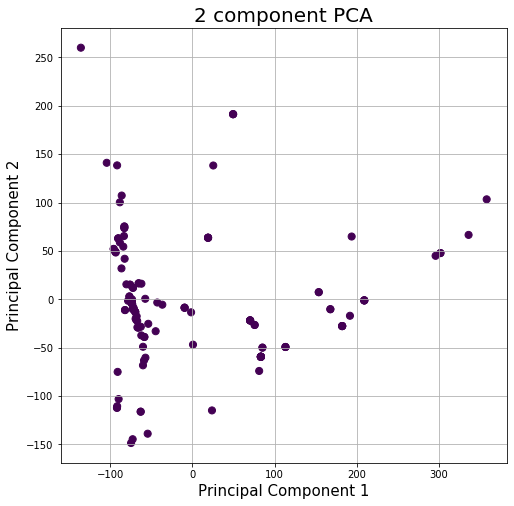

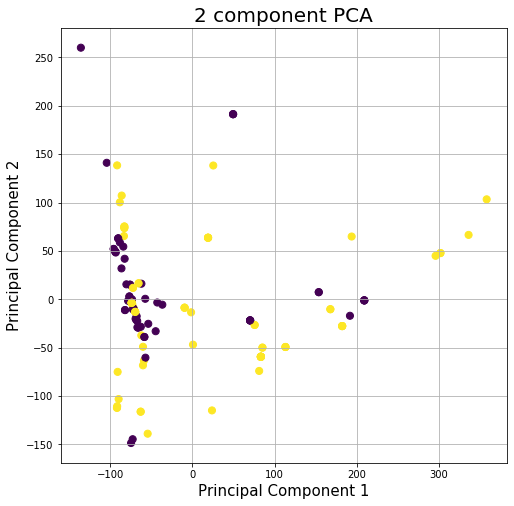

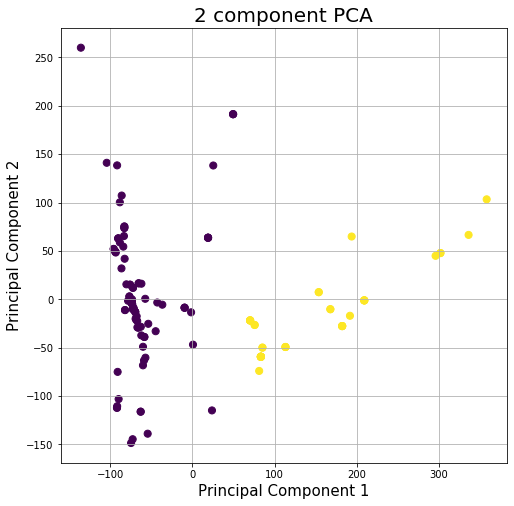

Second Example...


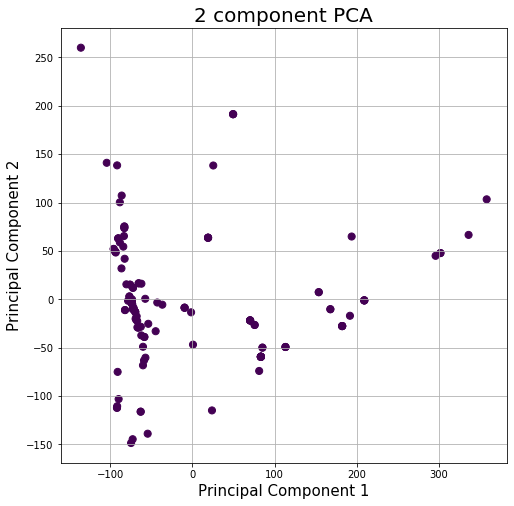

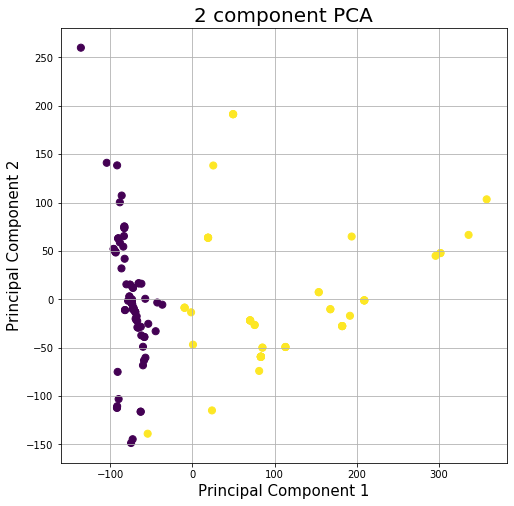

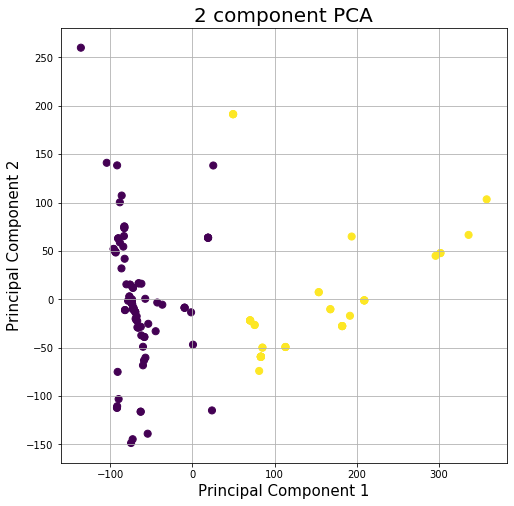

Third Example...


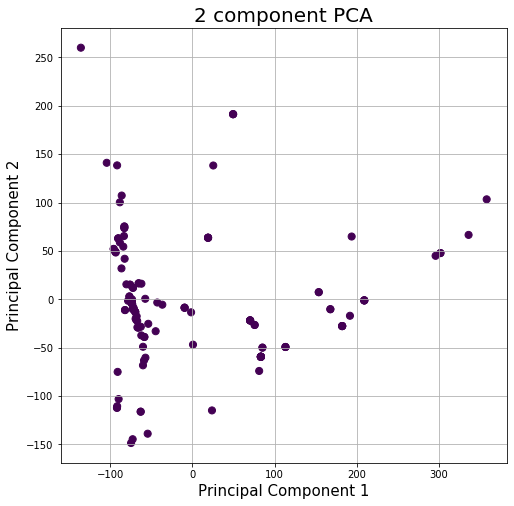

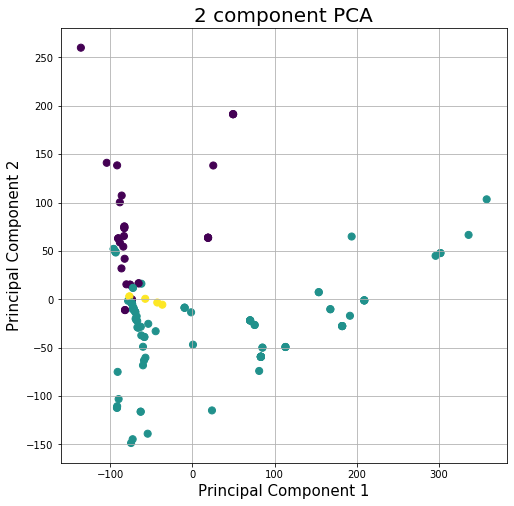

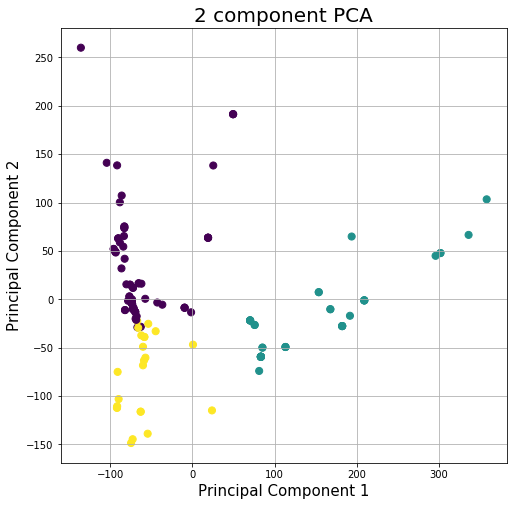

([array(['46495', '23812', '41729', '91911', '15813', '85232', '20856',
         '3458', '29047', '53272', '97218', '69893', '50018', '68578',
         '55996', '33838', '71389', '43878', '39939', '81697', '17622',
         '81859', '57370', '22711', '78796', '83741', '62186', '28919',
         '56394', '40084', '82886', '23319', '42296', '93168', '38472',
         '83227', '83394', '10701', '98170', '38846', '91426', '46975',
         '25551', '91194', '25196', '61242', '42074', '70005', '35014',
         '19267', '57644', '57481', '54203', '36257', '37438', '38181',
         '63634', '23760', '49624', '39117', '94652', '7780', '3733',
         '73183', '42202', '94719', '25878', '38031', '8304', '72058',
         '34958', '41719', '47023'], dtype=object),
  array(['13052', '82993', '64392', '42633', '57602', '58445', '6040',
         '52235', '46042', '34563', '7674', '91796', '63064', '24307',
         '63703', '8208', '81816', '34088', '17526', '29209', '94372',
         '73462', '

In [16]:
print('First Example...')
cluster_by_partitioning(active_sites, 2)
print('Second Example...')
cluster_by_partitioning(active_sites, 2)
print('Third Example...')
cluster_by_partitioning(active_sites, 3)

# cluster_hierarchically

This shows an example of how the clustering is performed step by step. I chose to cluster by complete linkage using the furthest point between every cluster as my data had some outliers which I did not want to have cluster individually. The First example below shows how 10 active sites would be clustered. Whereas, the second set show all active sites clustering. When 2 clusters are specified it will always be the same, unlike K-means as it is dependent upon distance.

First Example...


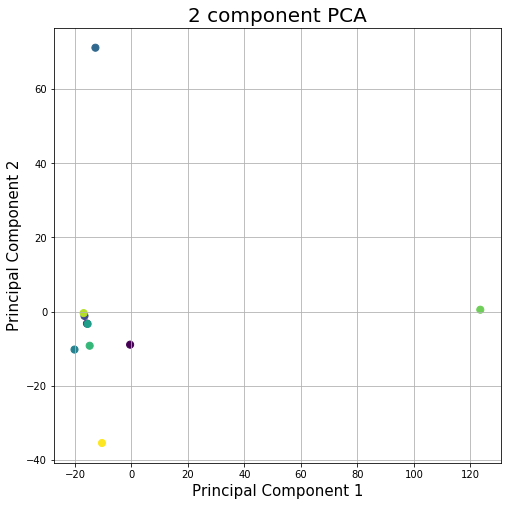

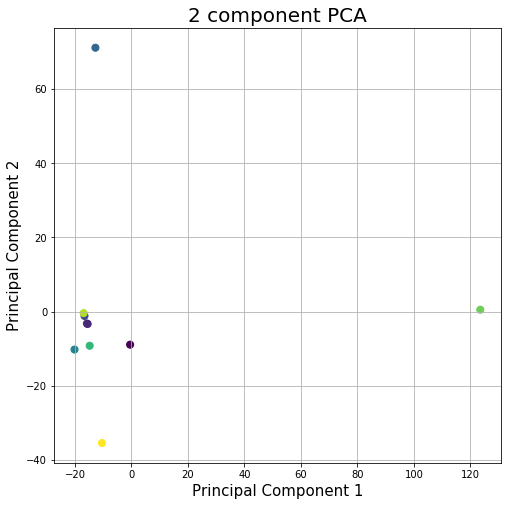

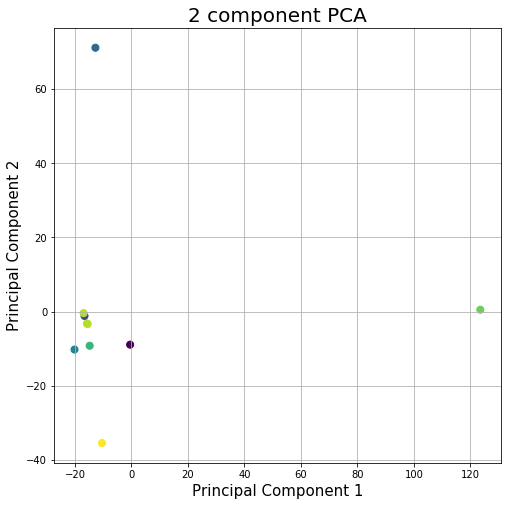

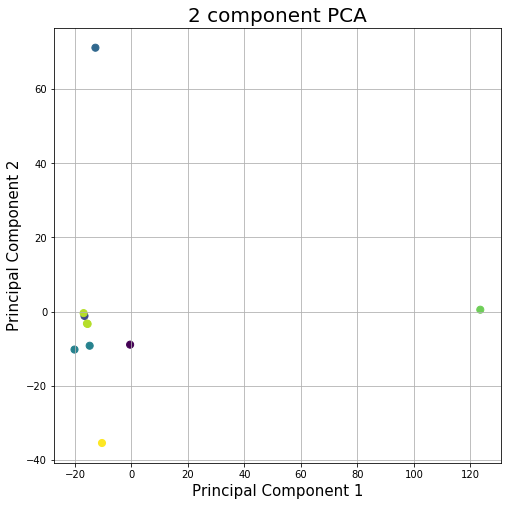

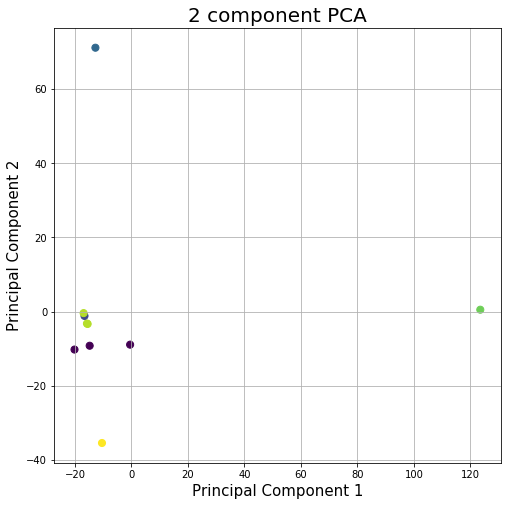

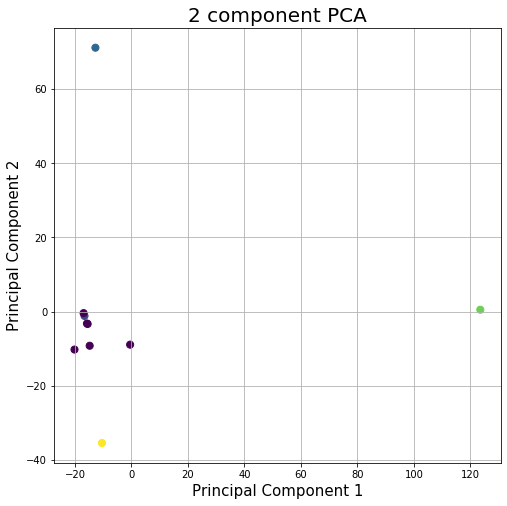

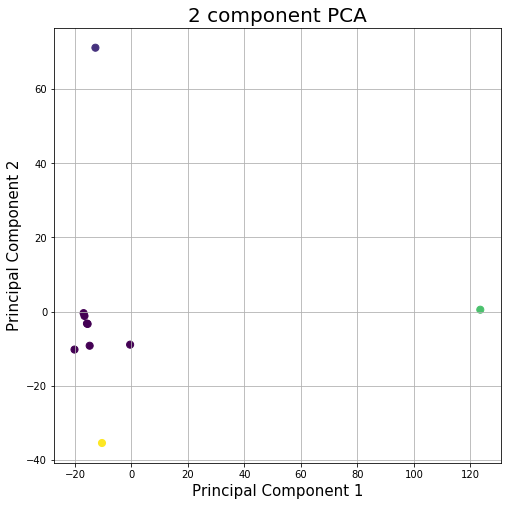

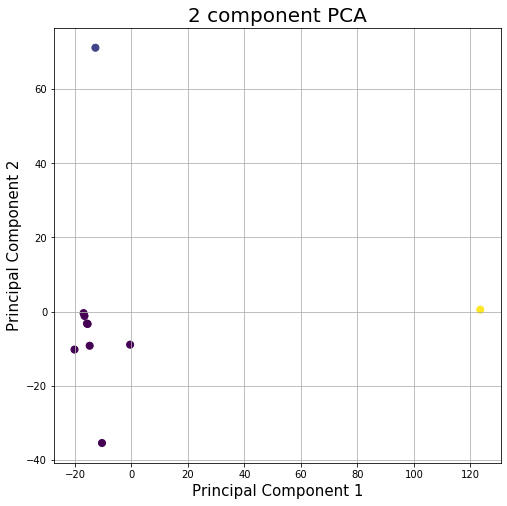

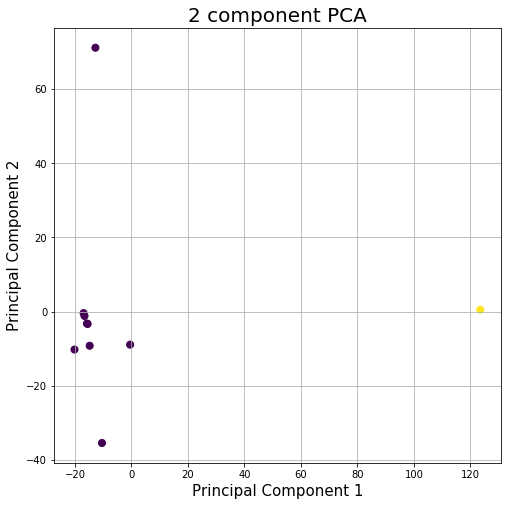

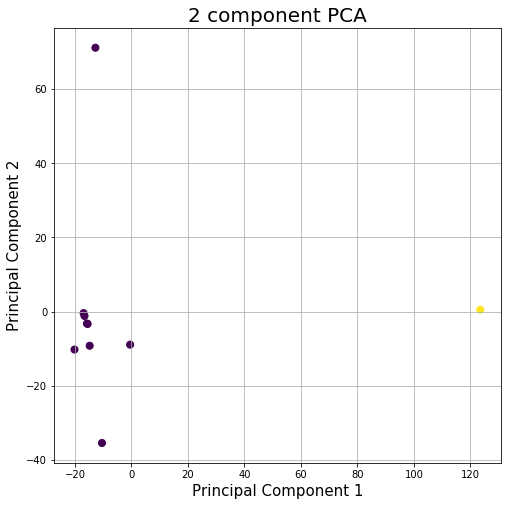

([array(['46495', '23812', '41729', '91911', '82212', '15813', '85232',
         '3458', '13052'], dtype=object), array(['20856'], dtype=object)],
                                      Scores  Cluster Active  \
 0   [34, 13, 15, 12, 11, 13, 17, 25, 13, 6]        3  46495   
 1   [13, 28, 18, 16, 12, 23, 12, 13, 23, 6]        3  23812   
 2   [15, 18, 71, 17, 13, 13, 24, 15, 21, 6]        3  41729   
 3   [12, 16, 17, 97, 12, 16, 12, 18, 18, 7]        3  91911   
 4    [11, 12, 13, 12, 28, 12, 23, 8, 12, 6]        3  82212   
 5   [13, 23, 13, 16, 12, 29, 12, 13, 24, 6]        3  15813   
 6   [17, 12, 24, 12, 23, 12, 34, 14, 18, 6]        3  85232   
 7  [25, 13, 15, 18, 8, 13, 14, 151, 13, 14]        7  20856   
 8   [13, 23, 21, 18, 12, 24, 18, 13, 39, 6]        3   3458   
 9          [6, 6, 6, 7, 6, 6, 6, 14, 6, 68]        3  13052   
 
    principal component 1  principal component 2  
 0              -0.479582              -8.886415  
 1             -15.762062              -3.188

In [23]:
print('First Example...')
cluster_hierarchically_print(active_sites[0:10], 2)

First Example...


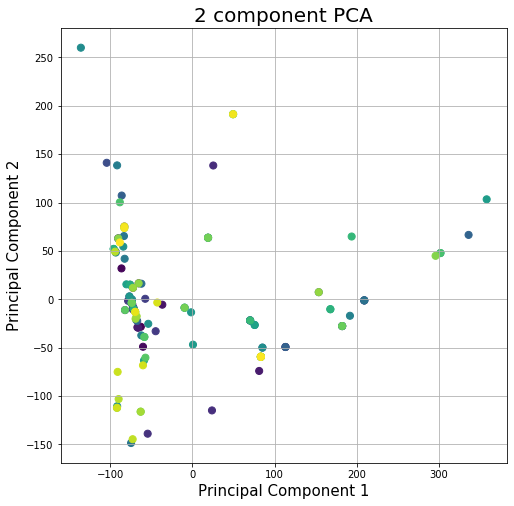

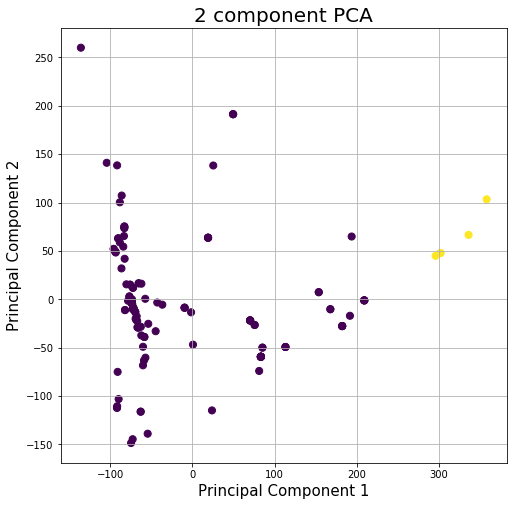

Second Example...


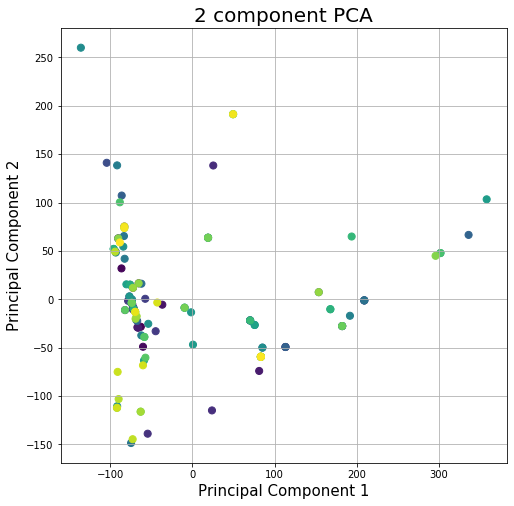

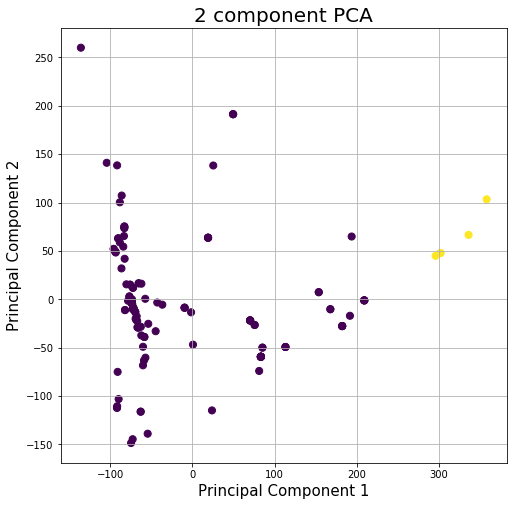

Third Example...


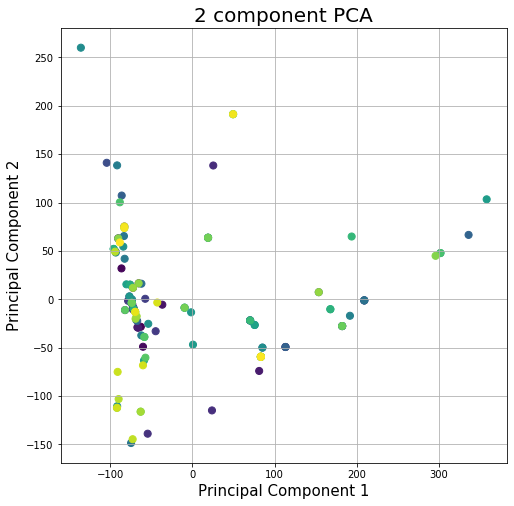

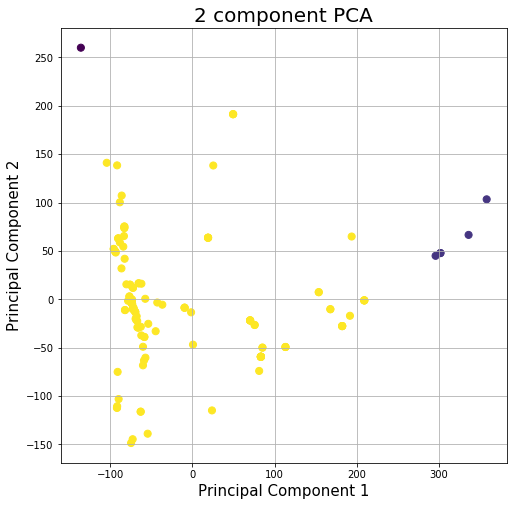

Fourth Example...


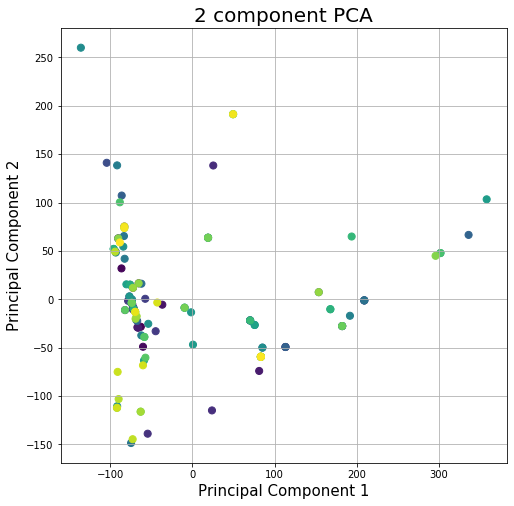

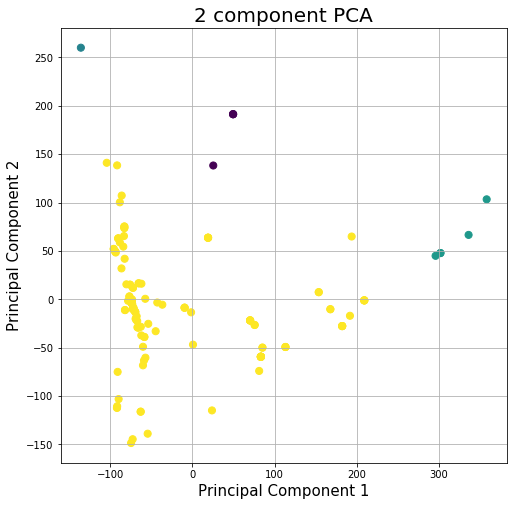

([array(['69893', '35014', '39117', '34958'], dtype=object),
  array(['10701'], dtype=object),
  array(['91796', '73462', '28672', '29773', '24634'], dtype=object),
  array(['46495', '23812', '41729', '91911', '82212', '15813', '85232',
         '20856', '3458', '13052', '82993', '32088', '64392', '29047',
         '42633', '53272', '97218', '96099', '82238', '50018', '68578',
         '55996', '93456', '33838', '71389', '43878', '57602', '58445',
         '39939', '81697', '17622', '81859', '6040', '57370', '22711',
         '52235', '46042', '34563', '78796', '9776', '83741', '7674',
         '63064', '24307', '63703', '8208', '62186', '28919', '56394',
         '81816', '34088', '37224', '40084', '82886', '23319', '42296',
         '93168', '42269', '17526', '38472', '83227', '29209', '83394',
         '94372', '93192', '98170', '85492', '38846', '91426', '27031',
         '46975', '25551', '91194', '18773', '37237', '25196', '61242',
         '56029', '42074', '70005', '19267', '18

In [27]:
print('First Example...')
cluster_hierarchically(active_sites, 2)
print('Second Example...')
cluster_hierarchically(active_sites, 2)
print('Third Example...')
cluster_hierarchically(active_sites, 3)
print('Fourth Example...')
cluster_hierarchically(active_sites, 4)

# Measure Quality of Clusters